# Analysis of flight cancellations and delays data

### About the database

Dataset of flight cancellations and delays for US airlines in January 2023, extracted from the US Department of Transportation, Bureau of Transportation Statistics (https://www.transstats.bts.gov) and available on Kaggle.

Variables include flight routes (origin and destination), time intervals between events (minutes, time at destination), reasons/attributions for delays and cancellations.

#### Variable description

##### DOT_CODE_DICTIONARY table

| Variable | Description |
| -------- | --------- |
| Code | Numeric identifier from the U.S. Department of Transportation (DOT) for airlines |
| Description | Airline description |

##### AIRLINE_CODE_DICTIONARY table

| Variable | Description |
| -------- | --------- |
| Code | Unique operator code for aircraft operator agencies |
| Description | Description of the aircraft operator agency |

##### flights_202301 table

| Variable | Description |
| -------- | --------- |
| FL_DATE | Flight date (yyyymmdd) |
| AIRLINE_CODE | Unique operator code. When multiple operators use the same code, a numeric suffix is used to differentiate previous users, e.g., PA, PA(1), PA(2). |
| DOT_CODE | Identification number assigned by the US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one that owns and reports under the same DOT certificate regardless of its code, name, or holding/company. |
| FL_NUMBER | Flight number |
| ORIGIN | Origin airport |
| ORIGIN_CITY | Origin airport, city name |
| DEST | Destination airport |
| DEST_CITY | Destination airport, city name |
| CRSDEPTIME | Scheduled departure time recorded in CRS (Computer Reservation System) (local time: hhmm) |
| DEP_TIME | Actual departure time (local time: hhmm) |
| DEP_DELAY | Difference in minutes between scheduled and actual departure time. Early departures show negative numbers. |
| TAXI_OUT | Taxi out time in minutes (taxi is the process of moving an airplane while it is on the runway) |
| WHEELS_OFF | Exact takeoff time (local time: hhmm) |
| WHEELS_ON | Exact landing time (local time: hhmm) |
| TAXI_IN | Taxi in time in minutes |
| CRSARRTIME | Scheduled arrival time recorded in CRS (local time: hhmm) |
| ARR_TIME | Actual arrival time (local time: hhmm) |
| ARR_DELAY | Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers. |
| CANCELLED | Flight cancelled indicator (1=Yes) |
| CANCELLATION_CODE | Specifies the reason for cancellation |
| DIVERTED | Flight diverted indicator (1=Yes) |
| CRSELAPSEDTIME | Total elapsed flight time in minutes recorded in CRS |
| ELAPSED_TIME | Total actual elapsed flight time in minutes |
| AIR_TIME | Air time in minutes |
| DISTANCE | Distance between airports (miles) |
| DELAYDUECARRIER | Carrier delay in minutes |
| DELAYDUEWEATHER | Weather delay in minutes |
| DELAYDUENAS | National Air System delay in minutes |
| DELAYDUESECURITY | Security delay in minutes |
| DELAYDUELATE_AIRCRAFT | Late aircraft delay in minutes |

## 1. Imports and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import zscore, ttest_ind, f_oneway, chi2_contingency
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

In [2]:
df_dot_code_dictionary = pd.read_excel("../dataset/DOT_CODE_DICTIONARY.xlsx")
df_airline_code_dictionary = pd.read_csv("../dataset/AIRLINE_CODE_DICTIONARY.csv")
df_flights_202301 = pd.read_csv("../dataset/flights_202301.csv")

In [3]:
df_flights_202301.drop(['FL_MONTH', 'FL_YEAR'], axis=1, inplace=True)

## 2. Data treatment

### a. Renaming columns to create a pattern

In [4]:
df_dot_code_dictionary = df_dot_code_dictionary.rename(
    columns=lambda col: f"DOT_{col}" if col != "Code" else col
)
df_airline_code_dictionary = df_airline_code_dictionary.rename(
    columns=lambda col: f"AIRLINE_{col}" if col != "Code" else col
)

### b. Checking initial information and dimensions

In [5]:
print(f"Shape of df_flights_202301: {df_flights_202301.shape}")
print(f"Shape of df_dot_code_dictionary: {df_dot_code_dictionary.shape}")
print(f"Shape of df_airline_code_dictionary: {df_airline_code_dictionary.shape}")

Shape of df_flights_202301: (538837, 31)
Shape of df_dot_code_dictionary: (1737, 2)
Shape of df_airline_code_dictionary: (1729, 2)


In [6]:
df_flights_202301.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538837 entries, 0 to 538836
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  538837 non-null  object 
 1   AIRLINE_CODE             538837 non-null  object 
 2   DOT_CODE                 538837 non-null  int64  
 3   FL_NUMBER                538837 non-null  int64  
 4   ORIGIN                   538837 non-null  object 
 5   ORIGIN_CITY              538837 non-null  object 
 6   DEST                     538837 non-null  object 
 7   DEST_CITY                538837 non-null  object 
 8   CRS_DEP_TIME             538837 non-null  int64  
 9   DEP_TIME                 528859 non-null  float64
 10  DEP_DELAY                528855 non-null  float64
 11  TAXI_OUT                 528640 non-null  float64
 12  WHEELS_OFF               528640 non-null  float64
 13  WHEELS_ON                528318 non-null  float64
 14  TAXI

In [7]:
df_airline_code_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Code                 1728 non-null   object
 1   AIRLINE_Description  1729 non-null   object
dtypes: object(2)
memory usage: 27.1+ KB


In [8]:
df_dot_code_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             1737 non-null   int64 
 1   DOT_Description  1733 non-null   object
dtypes: int64(1), object(1)
memory usage: 27.3+ KB


### c. Optimizing data types for df_flights_202301

In [9]:
df_flights_optimized = df_flights_202301.copy()

In [10]:
# 1. DATE CONVERSION

df_flights_optimized["FL_DATE"] = pd.to_datetime(
    df_flights_optimized["FL_DATE"].astype(str),
    format="%Y-%m-%d",
    errors='coerce'
)

df_flights_optimized["FL_DAY"] = df_flights_optimized["FL_DATE"] .dt.day.astype('float32')

In [11]:
# 2. CATEGORICAL COLUMNS

cols_category = [
    "AIRLINE_CODE", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CANCELLATION_CODE"
]
for col in cols_category:
    df_flights_optimized[col] = df_flights_optimized[col].astype("category")

In [12]:
# 3. BOOLEAN VARIABLES

df_flights_optimized["CANCELLED"] = df_flights_optimized["CANCELLED"].astype(bool)
df_flights_optimized["DIVERTED"] = df_flights_optimized["DIVERTED"].astype(bool)

In [13]:
# 4. FUNCTION FOR TIME CONVERSION
# Converter colunas de horários (HHMM) para int, ignorando erros

time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME", "AIR_TIME"]
for col in time_cols:
    if col in df_flights_optimized.columns:
        df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors="coerce")

In [14]:
# Converter atrasos e tempos para numérico
num_cols = ["TAXI_IN", "TAXI_OUT", "ELAPSED_TIME", "DEP_DELAY", "ARR_DELAY"]
for col in num_cols:
    if col in df_flights_optimized.columns:
        df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors="coerce")

In [15]:
# 5. NUMERIC TYPE OPTIMIZATION

# Columns that can be converted to smaller int (memory saving)
int_columns_small = ["FL_NUMBER", "DOT_CODE"]
for col in int_columns_small:
    if col in df_flights_optimized.columns:
        max_val = df_flights_optimized[col].max()
        if max_val <= 32767:  # int16
            df_flights_optimized[col] = df_flights_optimized[col].astype("int16")
        elif max_val <= 2147483647:  # int32
            df_flights_optimized[col] = df_flights_optimized[col].astype("int32")

# 'Distance' can likely be int16 (max ~32k miles)
if "DISTANCE" in df_flights_optimized.columns:
    df_flights_optimized["DISTANCE"] = df_flights_optimized["DISTANCE"].astype("int16")

# Convert to float32 (saves 50% memory vs float64)
float_columns = [
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY",
    "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME",
    "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"
]
for col in float_columns:
    if col in df_flights_optimized.columns:
        df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors='coerce')
        df_flights_optimized[col] = df_flights_optimized[col].astype("float32")

In [16]:
df_flights_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538837 entries, 0 to 538836
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FL_DATE                  538837 non-null  datetime64[ns]
 1   AIRLINE_CODE             538837 non-null  category      
 2   DOT_CODE                 538837 non-null  int16         
 3   FL_NUMBER                538837 non-null  int16         
 4   ORIGIN                   538837 non-null  category      
 5   ORIGIN_CITY              538837 non-null  category      
 6   DEST                     538837 non-null  category      
 7   DEST_CITY                538837 non-null  category      
 8   CRS_DEP_TIME             538837 non-null  int64         
 9   DEP_TIME                 528859 non-null  float64       
 10  DEP_DELAY                528855 non-null  float32       
 11  TAXI_OUT                 528640 non-null  float32       
 12  WHEELS_OFF      

### d. Optimizing data types for df_airline_code_dictionary

In [17]:
df_airline_optimized = df_airline_code_dictionary.copy()

In [18]:
# 1. Convert 'Code' to category
df_airline_optimized['Code'] = df_airline_optimized['Code'].astype('category')

# 2. Convert 'AIRLINE_Description' to category
df_airline_optimized['AIRLINE_Description'] = df_airline_optimized['AIRLINE_Description'].astype('category')

In [19]:
df_airline_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Code                 1728 non-null   category
 1   AIRLINE_Description  1729 non-null   category
dtypes: category(2)
memory usage: 163.0 KB


### e. Optimizing data types for df_dot_code_dictionary

In [20]:
df_dot_optimized = df_dot_code_dictionary.copy()

In [21]:
# 1. Convert to numeric type to ensure conversion works
df_dot_optimized['Code'] = pd.to_numeric(df_dot_optimized['Code'], errors='coerce')

# Check max value to choose best integer type
max_dot_code = df_dot_optimized['Code'].max()

if max_dot_code <= 32767:  # int16 limit
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int16')
elif max_dot_code <= 2147483647:  # int32 limit
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int32')

# 2. Convert 'DOT_Description' to category
df_dot_optimized['DOT_Description'] = df_dot_optimized['DOT_Description'].astype('category')

# 3. Remove the redundant part after ':'
df_dot_optimized["DOT_Description"] = df_dot_optimized["DOT_Description"].str.split(":").str[0].str.strip()

In [22]:
df_dot_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             1737 non-null   int16 
 1   DOT_Description  1733 non-null   object
dtypes: int16(1), object(1)
memory usage: 17.1+ KB


### f. Comparing optimized sizes

In [23]:
def compare_memory_usage(df_name, df_original, df_optimized):
    mem_original = df_original.memory_usage(deep=True).sum() / 1024**2
    mem_optimized = df_optimized.memory_usage(deep=True).sum() / 1024**2

    print(f"Memory improvement analysis for **{df_name}**")
    print(f"Original DataFrame: {mem_original:.2f} MB")
    print(f"Optimized DataFrame: {mem_optimized:.2f} MB")
    print(f"Savings: {mem_original - mem_optimized:.2f} MB ({((mem_original - mem_optimized) / mem_original * 100):.1f}%)")
    print("=" * 50)

compare_memory_usage("df_flights_202301", df_flights_202301, df_flights_optimized)
compare_memory_usage("df_airline_code_dictionary", df_airline_code_dictionary, df_airline_optimized)
compare_memory_usage("df_dot_code_dictionary", df_dot_code_dictionary, df_dot_optimized)

Memory improvement analysis for **df_flights_202301**
Original DataFrame: 298.05 MB
Optimized DataFrame: 64.86 MB
Savings: 233.20 MB (78.2%)
Memory improvement analysis for **df_airline_code_dictionary**
Original DataFrame: 0.20 MB
Optimized DataFrame: 0.33 MB
Savings: -0.13 MB (-66.2%)
Memory improvement analysis for **df_dot_code_dictionary**
Original DataFrame: 0.14 MB
Optimized DataFrame: 0.12 MB
Savings: 0.02 MB (13.3%)


### g. Merging data

Main: df_flights_202301

df_airline_code_dictionary: Code <> df_flights_202301: AIRLINE_CODE

df_dot_code_dictionary: Code <> df_flights_202301: DOT_CODE

In [24]:
df_merged = pd.merge(
    df_flights_optimized,
    df_dot_optimized,
    left_on="DOT_CODE",
    right_on="Code",
    how="left"
).drop(columns=["Code"])

df = pd.merge(
    df_merged,
    df_airline_optimized,
    left_on="AIRLINE_CODE",
    right_on="Code",
    how="left"
).drop(columns=["Code"])

### h. Checking and treating nulls values

In [25]:
def checkMissing(data,perc=0):
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0         DELAY_DUE_WEATHER   78.339832
1             DELAY_DUE_NAS   78.339832
2        DELAY_DUE_SECURITY   78.339832
3   DELAY_DUE_LATE_AIRCRAFT   78.339832
4         DELAY_DUE_CARRIER   78.339832
5                 ARR_DELAY    2.160208
6              ELAPSED_TIME    2.160208
7                  AIR_TIME    2.160208
8                   TAXI_IN    1.952167
9                 WHEELS_ON    1.952167
10                 ARR_TIME    1.952167
11                 TAXI_OUT    1.892409
12               WHEELS_OFF    1.892409
13                DEP_DELAY    1.852508
14                 DEP_TIME    1.851766
15         CRS_ELAPSED_TIME    0.000186


In [26]:
# Removing null in CRS_ELAPSED_TIME (1 value)
df = df.dropna(subset=["CRS_ELAPSED_TIME"])

In [27]:
# Checkin about the DELAYS in CANCELLED and DIVERTED
delay_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]

df_null_delays = df[df[delay_cols].isna().any(axis=1)]

delay_flag_0 = df_null_delays[(df_null_delays["CANCELLED"] == 0) & (df_null_delays["DIVERTED"] == 0)]
delay_flag_1 = df_null_delays[(df_null_delays["CANCELLED"] == 1) | (df_null_delays["DIVERTED"] == 1)]

total_rows = len(df)
prop_delay_flag_0 = len(delay_flag_0) / total_rows * 100
prop_delay_flag_1 = len(delay_flag_1) / total_rows * 100

print(f"Delay nulo em voo normal: {len(delay_flag_0):,} ({prop_delay_flag_0:.2f}%)")
print(f"Delay nulo em voo cancelado/desviado: {len(delay_flag_1):,} ({prop_delay_flag_1:.2f}%)")

dist = delay_flag_1[["CANCELLED", "DIVERTED"]].value_counts()
dist_prop = dist / total_rows * 100

print("\nDistribuição entre CANCELLED e DIVERTED (valores absolutos e % do total):")
print(pd.concat([dist, dist_prop.rename("proporção %")], axis=1))

all_delay_null = delay_flag_1[delay_flag_1[delay_cols].isna().all(axis=1)]

print(f"\nLinhas canceladas/desviadas com TODOS os 5 delays nulos: {len(all_delay_null):,}")

Delay nulo em voo normal: 410,484 (76.18%)
Delay nulo em voo cancelado/desviado: 11,639 (2.16%)

Distribuição entre CANCELLED e DIVERTED (valores absolutos e % do total):
                    count  proporção %
CANCELLED DIVERTED                    
True      False     10294     1.910414
False     True       1345     0.249612

Linhas canceladas/desviadas com TODOS os 5 delays nulos: 11,639


In [28]:
df.loc[df['CANCELLED'] == 0, delay_cols] = df.loc[df['CANCELLED'] == 0, delay_cols].fillna(0)

In [29]:
print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0                  AIR_TIME    2.160026
1              ELAPSED_TIME    2.160026
2                 ARR_DELAY    2.160026
3                   TAXI_IN    1.951985
4                  ARR_TIME    1.951985
5                 WHEELS_ON    1.951985
6         DELAY_DUE_CARRIER    1.910414
7         DELAY_DUE_WEATHER    1.910414
8             DELAY_DUE_NAS    1.910414
9        DELAY_DUE_SECURITY    1.910414
10  DELAY_DUE_LATE_AIRCRAFT    1.910414
11               WHEELS_OFF    1.892227
12                 TAXI_OUT    1.892227
13                DEP_DELAY    1.852326
14                 DEP_TIME    1.851584


### i. Checking duplicated values

In [30]:
df.duplicated().any()

np.False_

### j. Checking out-of-scope variable data 

In [31]:
# 1. Dates out-of-scope: 2023, january
print(df["FL_DATE"].min(), "→", df["FL_DATE"].max())

2023-01-01 00:00:00 → 2023-01-31 00:00:00


In [32]:
# 2. Checking expected ranges

check_ranges = {
    "FL_DAY": (1, 31),
    "DEP_TIME": (0, 2359),
    "ARR_TIME": (0, 2359),
    "CRS_DEP_TIME": (0, 2359),
    "CRS_ARR_TIME": (0, 2359),
    "TAXI_IN": (0, None),
    "TAXI_OUT": (0, None),
    "ELAPSED_TIME": (0, None),
    "AIR_TIME": (0, None),
    "DEP_DELAY": (None, None),
    "ARR_DELAY": (None, None),
}

for col, (low, high) in check_ranges.items():
    if col in df.columns:
        if low is not None:
            invalid_low = df[df[col] < low]
            if not invalid_low.empty:
                print(f"{col}: {len(invalid_low)} valores abaixo de {low}")
        if high is not None:
            invalid_high = df[df[col] > high]
            if not invalid_high.empty:
                print(f"{col}: {len(invalid_high)} valores acima de {high}")

DEP_TIME: 48 valores acima de 2359
ARR_TIME: 281 valores acima de 2359


In [33]:
invalid_dep_time_vals = df.loc[df["DEP_TIME"] > 2359, "DEP_TIME"].unique()
print("DEP_TIME inválidos únicos:", invalid_dep_time_vals)

invalid_arr_time_vals = df.loc[df["ARR_TIME"] > 2359, "ARR_TIME"].unique()
print("ARR_TIME inválidos únicos:", invalid_arr_time_vals)

DEP_TIME inválidos únicos: [2400.]
ARR_TIME inválidos únicos: [2400.]


In [34]:
time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]

for col in time_cols:
    if col in df.columns:
        df.loc[df[col] == 2400, col] = 0

### k. Checking the categorical data

In [35]:
# 1. List information about categorical data

categorical_data = df.select_dtypes(include=['object', 'category']).columns

print("🔎 Exploração de valores categóricos:\n")
print(categorical_data)

for data_column in categorical_data:
    print(f"📌 Coluna: {data_column}")
    print("Quantidade de categorias únicas:", df[data_column].nunique())
    print("Categorias encontradas:", df[data_column].unique())
    print("-" * 80)

🔎 Exploração de valores categóricos:

Index(['AIRLINE_CODE', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CANCELLATION_CODE', 'DOT_Description', 'AIRLINE_Description'],
      dtype='object')
📌 Coluna: AIRLINE_CODE
Quantidade de categorias únicas: 15
Categorias encontradas: ['9E' 'AA' 'AS' 'B6' 'DL' 'F9' 'G4' 'HA' 'MQ' 'NK' 'WN' 'YX' 'OH' 'OO'
 'UA']
--------------------------------------------------------------------------------
📌 Coluna: ORIGIN
Quantidade de categorias únicas: 339
Categorias encontradas: ['BDL', 'LGA', 'DLH', 'ATL', 'FAY', ..., 'APN', 'PLN', 'BJI', 'GUM', 'SPN']
Length: 339
Categories (339, object): ['ABE', 'ABI', 'ABQ', 'ABR', ..., 'XNA', 'XWA', 'YAK', 'YUM']
--------------------------------------------------------------------------------
📌 Coluna: ORIGIN_CITY
Quantidade de categorias únicas: 333
Categorias encontradas: ['Hartford, CT', 'New York, NY', 'Duluth, MN', 'Atlanta, GA', 'Fayetteville, NC', ..., 'Alpena, MI', 'Pellston, MI', 'Bemidji, MN', 'Guam, T

In [36]:
# 2. Create pattern
    
df[categorical_data] = df[categorical_data].apply(
    lambda col: col.astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(['NA', 'N/A', 'NONE', 'NULL', '?', 'UNKNOWN'], np.nan)
)

if 'DOT_Description' in df.columns:
    df['DOT_Description'] = df['DOT_Description'].str.strip()

In [37]:
# 3. Checking similarity in DOT_Description and AIRLINE_Description

count_DOT_Description = df['DOT_Description'].value_counts()
print(count_DOT_Description)

count_AIRLINE_Description = df['AIRLINE_Description'].value_counts()
print(f"\n{count_AIRLINE_Description}")

DOT_Description
SOUTHWEST AIRLINES CO.    112430
DELTA AIR LINES INC.       75174
AMERICAN AIRLINES INC.     74999
UNITED AIR LINES INC.      56657
SKYWEST AIRLINES INC.      50346
REPUBLIC AIRLINE           24476
JETBLUE AIRWAYS            23249
SPIRIT AIR LINES           21876
ALASKA AIRLINES INC.       19801
ENVOY AIR                  18849
ENDEAVOR AIR INC.          16926
PSA AIRLINES INC.          15456
FRONTIER AIRLINES INC.     13285
ALLEGIANT AIR               8615
HAWAIIAN AIRLINES INC.      6697
Name: count, dtype: int64

AIRLINE_Description
SOUTHWEST AIRLINES CO.    112430
DELTA AIR LINES INC.       75174
AMERICAN AIRLINES INC.     74999
UNITED AIR LINES INC.      56657
SKYWEST AIRLINES INC.      50346
REPUBLIC AIRLINE           24476
JETBLUE AIRWAYS            23249
SPIRIT AIR LINES           21876
ALASKA AIRLINES INC.       19801
ENVOY AIR                  18849
ENDEAVOR AIR INC.          16926
PSA AIRLINES INC.          15456
FRONTIER AIRLINES INC.     13285
ALLEGIANT AIR

In [38]:
# Lines are the same?
similar_description = (df['DOT_Description'] == df['AIRLINE_Description']).all()
print("As colunas são idênticas linha a linha?", similar_description)

if not similar_description:
    dif = df[df['DOT_Description'] != df['AIRLINE_Description']]
    print(f"Número de diferenças: {len(dif)}")
    print(dif.head())

#  Same unique values?
similar_category = set(df['DOT_Description'].dropna().unique()) == set(df['AIRLINE_Description'].dropna().unique())
print("As colunas têm os mesmos valores únicos?", similar_category)

As colunas são idênticas linha a linha? True
As colunas têm os mesmos valores únicos? True


In [39]:
# Removing DOT_DESCRIPTION
df = df.drop('DOT_Description', axis=1)

In [40]:
# 4. Checking inconsistent values
categorical_data = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_data:
    print(f"{col}: {df[col].isin(['NA','?','None','UNKNOWN']).sum()} valores suspeitos")

AIRLINE_CODE: 0 valores suspeitos
ORIGIN: 0 valores suspeitos
ORIGIN_CITY: 0 valores suspeitos
DEST: 0 valores suspeitos
DEST_CITY: 0 valores suspeitos
CANCELLATION_CODE: 0 valores suspeitos
AIRLINE_Description: 0 valores suspeitos


### l. Checking the numerical data

In [41]:
numeric_cols = df.select_dtypes(include='number').columns.tolist()

def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

def detect_outliers_zscore(series, threshold=3):
    z_scores = zscore(series.dropna())
    return series.iloc[(abs(z_scores) > threshold).nonzero()[0]]

outliers_iqr, outliers_zscore = {}, {}

for col in numeric_cols:
    if col in df_merged.columns:
        outliers_iqr[col] = detect_outliers_iqr(df_merged[col])
        outliers_zscore[col] = detect_outliers_zscore(df_merged[col])

print("🔎 Outliers identificados (IQR):")
for col, vals in outliers_iqr.items():
    print(f"- {col}: {len(vals)} registros")

print("\n🔎 Outliers identificados (Z-Score):")
for col, vals in outliers_zscore.items():
    print(f"- {col}: {len(vals)} registros")


🔎 Outliers identificados (IQR):
- DOT_CODE: 0 registros
- FL_NUMBER: 131 registros
- CRS_DEP_TIME: 0 registros
- DEP_TIME: 0 registros
- DEP_DELAY: 65189 registros
- TAXI_OUT: 35661 registros
- WHEELS_OFF: 0 registros
- WHEELS_ON: 0 registros
- TAXI_IN: 36666 registros
- CRS_ARR_TIME: 0 registros
- ARR_TIME: 0 registros
- ARR_DELAY: 48102 registros
- CRS_ELAPSED_TIME: 27542 registros
- ELAPSED_TIME: 25005 registros
- AIR_TIME: 26674 registros
- DISTANCE: 32099 registros
- DELAY_DUE_CARRIER: 12005 registros
- DELAY_DUE_WEATHER: 6507 registros
- DELAY_DUE_NAS: 8966 registros
- DELAY_DUE_SECURITY: 626 registros
- DELAY_DUE_LATE_AIRCRAFT: 12750 registros
- FL_DAY: 0 registros

🔎 Outliers identificados (Z-Score):
- DOT_CODE: 0 registros
- FL_NUMBER: 67 registros
- CRS_DEP_TIME: 0 registros
- DEP_TIME: 0 registros
- DEP_DELAY: 7656 registros
- TAXI_OUT: 9732 registros
- WHEELS_OFF: 0 registros
- WHEELS_ON: 0 registros
- TAXI_IN: 10083 registros
- CRS_ARR_TIME: 0 registros
- ARR_TIME: 0 regis

### m. Creating new variable

In [42]:
# Delays metrics

df['DELAY_TOTAL'] = df['DELAY_DUE_CARRIER'] + df['DELAY_DUE_WEATHER'] + df['DELAY_DUE_NAS'] + df['DELAY_DUE_SECURITY'] + df['DELAY_DUE_LATE_AIRCRAFT']
df['DELAY_TOTAL'] = df['DELAY_TOTAL'].astype(np.float64)

df['DELAY_OVERALL'] = df['ARR_DELAY'].apply(lambda x: x if x > 0 else 0)
df['DELAY_OVERALL'] = df['DELAY_OVERALL'].astype(np.int64)

df['DELAY'] = df['DELAY_OVERALL'].apply(lambda x: 1 if x > 0 else 0)
df['DELAY'] = df['DELAY'].astype(bool)

In [43]:
# Categorization by time of day
df['TIME_PERIOD'] = pd.cut(df['DEP_TIME'], bins=[0, 600, 1200, 1800, 2400], 
                           labels=['Early Morning','Morning','Afternoon','Evening'], right=False)

In [44]:
# Categorization by time of week
df["DAY_OF_WEEK"] = df["FL_DATE"] .dt.day_name()

In [45]:
columns_problematic = ['DELAY', 'CANCELLED', 'DIVERTED']

## 3. Exploratory Data Analysis (EDA)

### a. Merge and see categorial information

In [46]:
# Count of delayed, cancelled and diverted flights
for col in columns_problematic:
    print(f"Coluna: {col} | Soma: {df[col].sum()}")
    print("-" * 30)

Coluna: DELAY | Soma: 202575
------------------------------
Coluna: CANCELLED | Soma: 10294
------------------------------
Coluna: DIVERTED | Soma: 1345
------------------------------


In [57]:
# Top 10 airlines with most problems (delays, cancellations, diversions)
results_airline = []

for col in columns_problematic:
    top_prob_airlines = (
        df.groupby("AIRLINE_Description")[col]
          .sum()
          .nlargest(10)
    )
    results_airline.append(top_prob_airlines.rename(col))

summary_table_airline = pd.concat(results_airline, axis=1).fillna(0).astype(int)
summary_table_airline = summary_table_airline.sort_values("DELAY", ascending=False)

print("Quantidade dos Problemas por Companhia Aérea, ordenado por quantidade de DELAY:")
display(summary_table_airline.head(10))

Quantidade dos Problemas por Companhia Aérea, ordenado por quantidade de DELAY:


,DELAY,CANCELLED,DIVERTED
AIRLINE_Description,,,
SOUTHWEST AIRLINES CO.,40279,3234,197
AMERICAN AIRLINES INC.,29391,1417,128
DELTA AIR LINES INC.,26647,586,169
UNITED AIR LINES INC.,21920,415,140
SKYWEST AIRLINES INC.,19391,1669,299
SPIRIT AIR LINES,9715,507,0
JETBLUE AIRWAYS,9322,0,77
ALASKA AIRLINES INC.,7701,280,100
ENVOY AIR,7528,482,42


In [48]:
# Average departure delay by airline
avg_delay_airline = df.groupby("AIRLINE_Description")["DELAY_OVERALL"].mean().sort_values(ascending=False)
print("Average Departure Delay Overall by Airline:")
print(avg_delay_airline)

Average Departure Delay Overall by Airline:
AIRLINE_Description
FRONTIER AIRLINES INC.    27.184720
ALLEGIANT AIR             23.734301
SPIRIT AIR LINES          20.860898
JETBLUE AIRWAYS           20.785668
AMERICAN AIRLINES INC.    18.576048
SKYWEST AIRLINES INC.     18.331089
ENDEAVOR AIR INC.         17.053173
UNITED AIR LINES INC.     17.039624
DELTA AIR LINES INC.      15.668582
ENVOY AIR                 14.107008
HAWAIIAN AIRLINES INC.    12.728535
SOUTHWEST AIRLINES CO.    12.363906
ALASKA AIRLINES INC.      11.868744
PSA AIRLINES INC.         11.172360
REPUBLIC AIRLINE          10.802214
Name: DELAY_OVERALL, dtype: float64


In [60]:
# Top 10 city origin with most problems (delays, cancellations, diversions)

results_city = []

for col in columns_problematic:
    top_prob_airlines = (
        df.groupby("ORIGIN_CITY")[col]
          .sum()
          .nlargest(10)
    )
    results_city.append(top_prob_airlines.rename(col))

summary_table_city = pd.concat(results_city, axis=1).fillna(0).astype(int)
summary_table_city = summary_table_city.sort_values("DELAY", ascending=False)

print("Quantidade dos Problemas por Cidade de Origem, ordenado por quantidade de DELAY:")
display(summary_table_city.head(10))

Quantidade dos Problemas por Cidade de Origem, ordenado por quantidade de DELAY:


,DELAY,CANCELLED,DIVERTED
ORIGIN_CITY,,,
"CHICAGO, IL",11412,570,65
"DENVER, CO",10666,786,65
"ATLANTA, GA",10316,0,68
"DALLAS/FORT WORTH, TX",7919,743,77
"NEW YORK, NY",7904,379,51
"LAS VEGAS, NV",6837,291,0
"ORLANDO, FL",6274,0,0
"CHARLOTTE, NC",6044,0,0
"PHOENIX, AZ",5608,0,44


In [50]:
# Average departure delay by city origin
avg_delay_city = df.groupby("ORIGIN_CITY")["DELAY_OVERALL"].mean().sort_values(ascending=False)
print("Average Departure Delay Overall by Origin City:")
print(avg_delay_city.head(10))

Average Departure Delay Overall by Origin City:
ORIGIN_CITY
RIVERTON/LANDER, WY        68.774194
PRESCOTT, AZ               48.868852
NORTH BEND/COOS BAY, OR    47.333333
CLARKSBURG/FAIRMONT, WV    46.400000
ESCANABA, MI               46.245902
TEXARKANA, AR              44.422222
POCATELLO, ID              41.741935
WILLISTON, ND              40.813084
NORTH PLATTE, NE           40.807229
JACKSON, WY                40.145098
Name: DELAY_OVERALL, dtype: float64


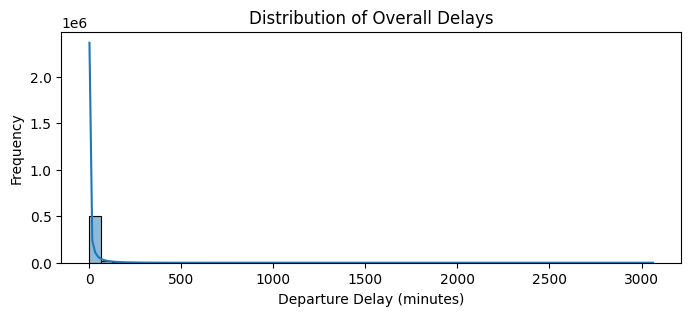

In [51]:
# Distribution of departure delays
plt.figure(figsize=(8, 3))
sns.histplot(df["DELAY_OVERALL"].dropna(), bins=50, kde=True)
plt.title("Distribution of Overall Delays")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

C:\Users\Vitoria\AppData\Local\Temp\ipykernel_33728\1381967164.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


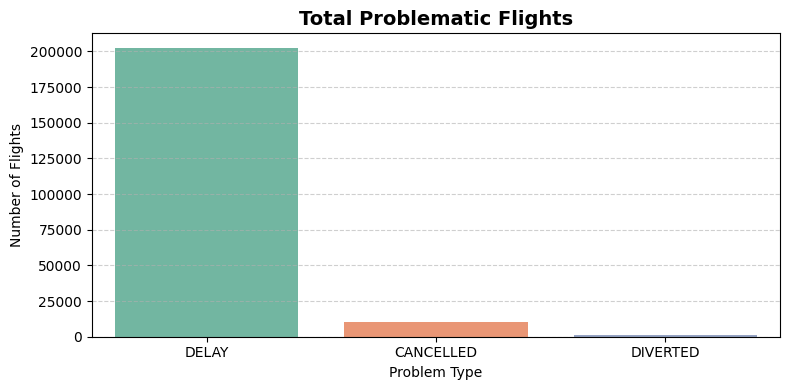

In [66]:
# Bar chart of problematic flights (binary columns 0/1)
problem_counts = df[columns_problematic].sum().reset_index()
problem_counts.columns = ["Problem_Type", "Count"]

plt.figure(figsize=(8, 4))
sns.barplot(
    data=problem_counts,
    x="Problem_Type",
    y="Count",
    palette="Set2"
)

plt.title("Total Problematic Flights", fontsize=14, fontweight="bold")
plt.xlabel("Problem Type")
plt.ylabel("Number of Flights")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

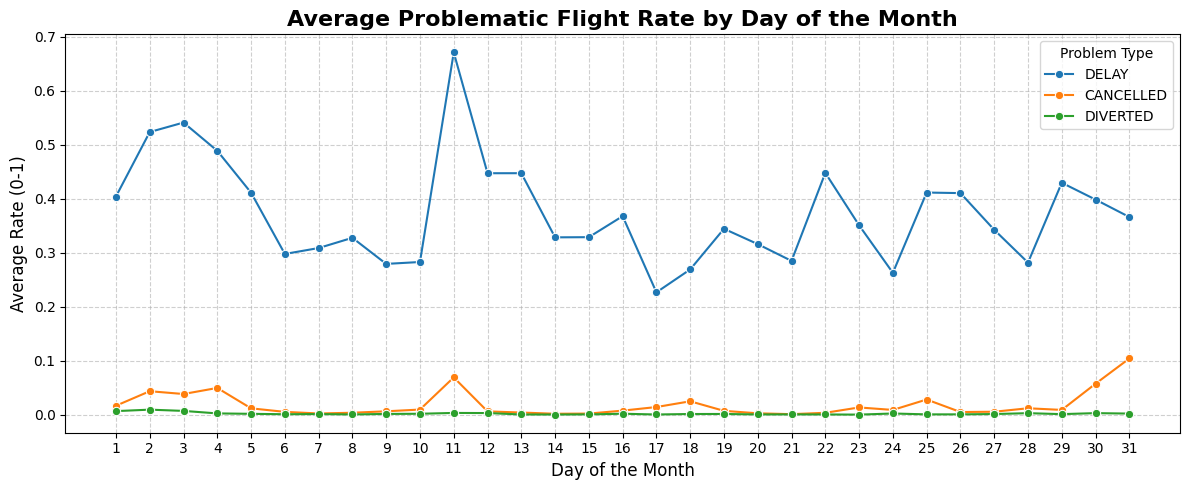

In [70]:
# Distribution of problematic flights by day of the month (line version)
delay_by_day_number = df.groupby("FL_DAY")[columns_problematic].mean().reset_index()

# Melt to long format
delay_melted = delay_by_day_number.melt(
    id_vars="FL_DAY",
    value_vars=columns_problematic,
    var_name="Problem_Type",
    value_name="Rate"
)

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=delay_melted,
    x="FL_DAY",
    y="Rate",
    hue="Problem_Type",
    marker="o"
)

plt.title("Average Problematic Flight Rate by Day of the Month", fontsize=16, fontweight="bold")
plt.xlabel("Day of the Month", fontsize=12)
plt.ylabel("Average Rate (0-1)", fontsize=12)
plt.xticks(range(1, 32))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Problem Type")
plt.tight_layout()
plt.show()


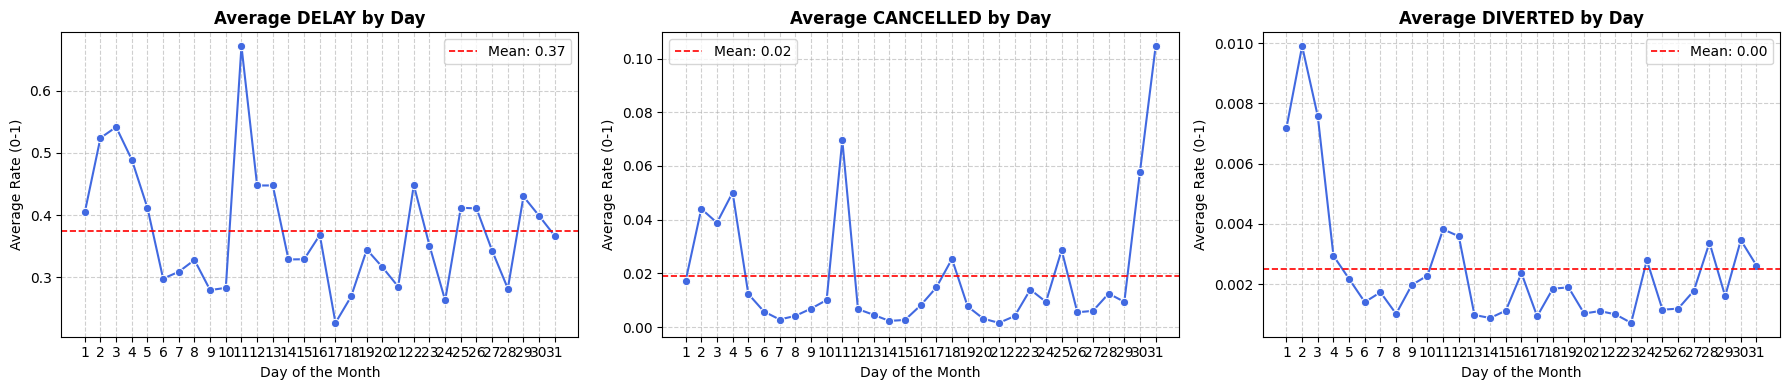

In [72]:
# Distribution of problematic flights by day of the month - separate subplots with mean line
delay_by_day_number = df.groupby("FL_DAY")[columns_problematic].mean().reset_index()

fig, axes = plt.subplots(1, len(columns_problematic), figsize=(18, 4), sharex=True)

for i, col in enumerate(columns_problematic):
    sns.lineplot(
        data=delay_by_day_number,
        x="FL_DAY",
        y=col,
        marker="o",
        color="royalblue",
        ax=axes[i]
    )
    
    # Mean line
    mean_val = delay_by_day_number[col].mean()
    axes[i].axhline(mean_val, color="red", linestyle="--", linewidth=1.2, label=f"Mean: {mean_val:.2f}")
    
    # Titles and labels
    axes[i].set_title(f"Average {col} by Day", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Day of the Month")
    axes[i].set_ylabel("Average Rate (0-1)")
    axes[i].set_xticks(range(1, 32))
    axes[i].grid(True, linestyle="--", alpha=0.6)
    axes[i].legend()

plt.tight_layout()
plt.show()


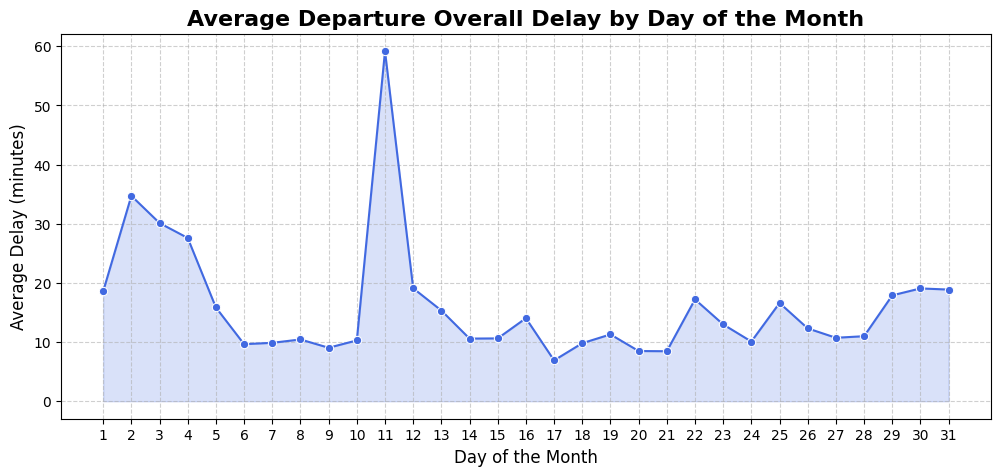

In [68]:
# Distribution of departure delays by day of the month - line version
delay_by_day_number = df.groupby("FL_DAY")["DELAY_OVERALL"].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(x="FL_DAY", y="DELAY_OVERALL", data=delay_by_day_number, marker="o", color="royalblue")
plt.fill_between(delay_by_day_number["FL_DAY"], delay_by_day_number["DELAY_OVERALL"], alpha=0.2, color="royalblue")
plt.title("Average Departure Overall Delay by Day of the Month", fontsize=16, fontweight="bold")
plt.xlabel("Day of the Month", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(range(1, 32))
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### b. Apply measures of central tendency and dispersion measures

In [ ]:
analysis_columns = ['CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'FL_DAY', 'DELAY_TOTAL', 'DELAY_OVERALL']

In [ ]:
central_tendency_dic = {}

for col in analysis_columns:
    if col in df.columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode()
        mode_val = mode.iloc[0] if not mode.empty else None
        std_dev = df[col].std()
        central_tendency_dic[col] = {
            'Mean': mean,
            'Median': median,
            'Mode': mode_val,
            'Standard Deviation': std_dev
        }

df_central_tendency_dic = pd.DataFrame(central_tendency_dic).T

print("Central Tendency Measures (numeric variables):")
display(df_central_tendency_dic)

Central Tendency Measures (numeric variables):


,Mean,Median,Mode,Standard Deviation
CRS_DEP_TIME,1327.415986,1320.0,600.0,489.903054
DEP_TIME,1334.224064,1327.0,555.0,502.485952
DEP_DELAY,12.937247,-2.0,-5.0,55.435947
TAXI_OUT,18.334566,15.0,13.0,10.624460
WHEELS_OFF,1358.483518,1341.0,611.0,503.858558
WHEELS_ON,1471.856121,1509.0,1627.0,532.185174
TAXI_IN,8.038000,6.0,4.0,6.416574
CRS_ARR_TIME,1497.177997,1520.0,2359.0,515.237173
ARR_TIME,1474.041206,1512.0,1150.0,538.082055
ARR_DELAY,7.776393,-5.0,-12.0,57.396809


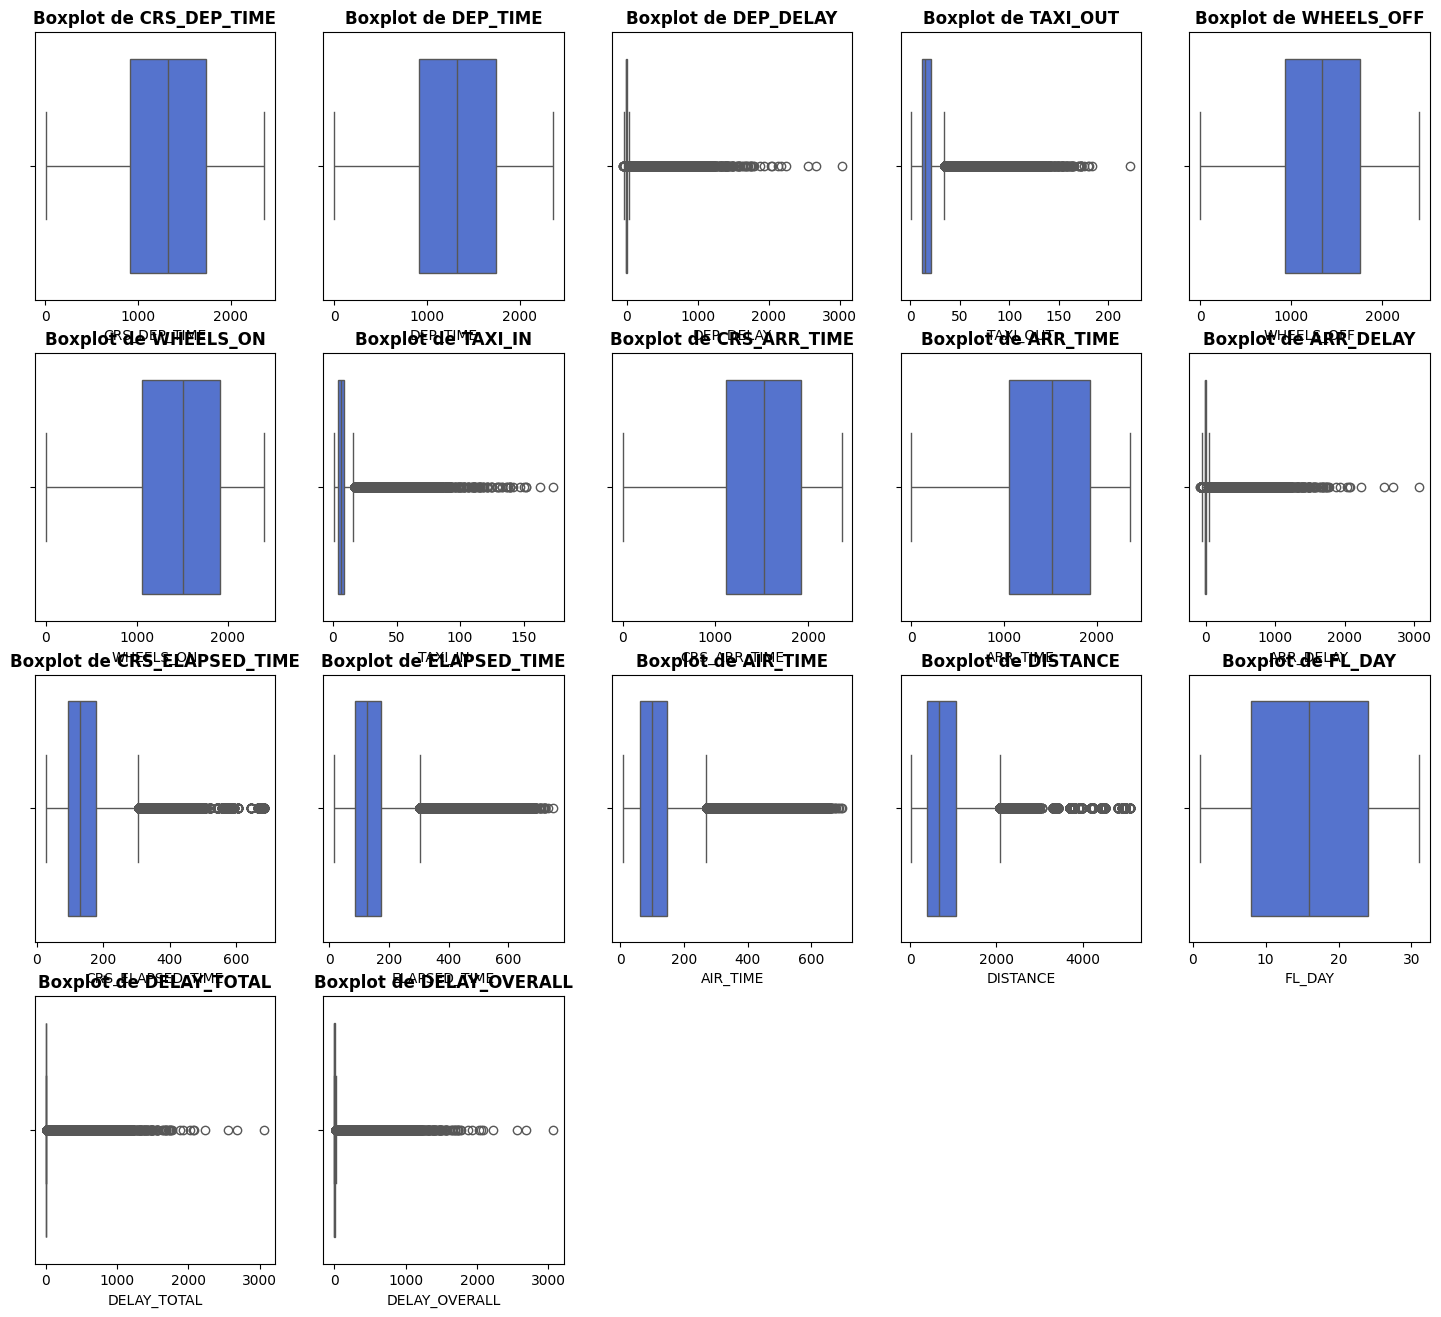

In [ ]:
# Boxplots

n_cols = 5
n_rows = math.ceil(len(analysis_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.boxplot(x=df[col], color="royalblue", ax=axes[i])
        axes[i].set_title(f"Boxplot de {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("")

# Remove eixos extras
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### c. See distribution

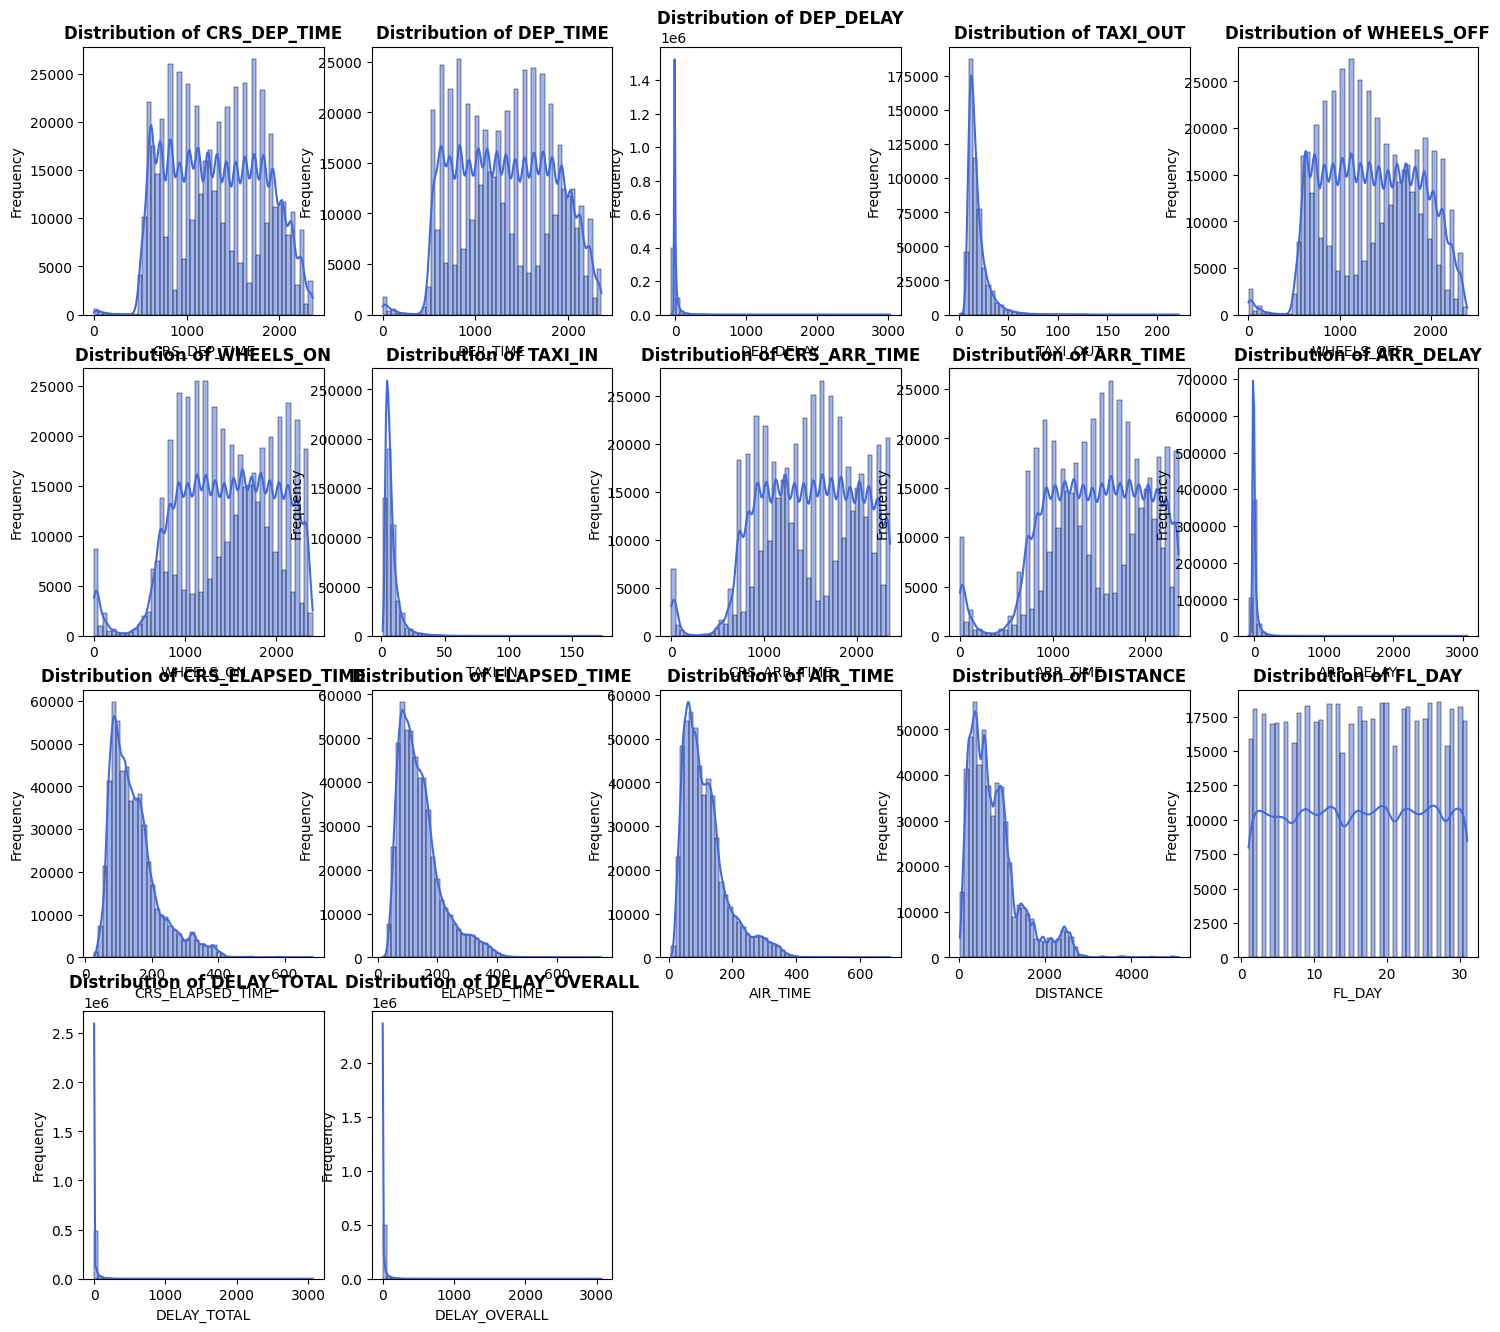

In [ ]:
# Histograms

n_cols = 5
n_rows = math.ceil(len(analysis_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(analysis_columns):
    if col in df.columns:
        sns.histplot(df[col], bins=50, kde=True, color="royalblue", ax=axes[i])
        axes[i].set_title(f"Distribution of {col}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### d. Calculate quarters, tenths or percents

In [ ]:
# Pearson correlation matrix
correlation_matrix = df[analysis_columns].corr(method='pearson')
display(correlation_matrix.round(2))

,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,FL_DAY,DELAY_TOTAL,DELAY_OVERALL
CRS_DEP_TIME,1.00,0.95,0.06,-0.05,0.92,0.63,-0.03,0.70,0.59,0.06,-0.03,-0.02,-0.02,-0.01,-0.01,0.04,0.04
DEP_TIME,0.95,1.00,0.10,-0.04,0.97,0.65,-0.03,0.70,0.62,0.10,-0.03,-0.03,-0.02,-0.02,-0.01,0.08,0.08
DEP_DELAY,0.06,0.10,1.00,0.06,0.10,0.02,0.02,0.05,0.01,0.97,0.03,0.04,0.03,0.03,-0.07,0.97,0.97
TAXI_OUT,-0.05,-0.04,0.06,1.00,-0.01,-0.02,0.02,-0.02,-0.02,0.21,0.07,0.19,0.04,0.03,0.06,0.17,0.17
WHEELS_OFF,0.92,0.97,0.10,-0.01,1.00,0.68,-0.03,0.72,0.64,0.10,-0.04,-0.04,-0.03,-0.03,-0.01,0.08,0.08
WHEELS_ON,0.63,0.65,0.02,-0.02,0.68,1.00,-0.01,0.84,0.95,0.03,0.00,0.01,0.02,0.01,0.01,0.01,0.01
TAXI_IN,-0.03,-0.03,0.02,0.02,-0.03,-0.01,1.00,-0.01,-0.01,0.10,0.11,0.17,0.09,0.08,-0.01,0.08,0.08
CRS_ARR_TIME,0.70,0.70,0.05,-0.02,0.72,0.84,-0.01,1.00,0.82,0.05,0.02,0.02,0.02,0.02,0.00,0.04,0.04
ARR_TIME,0.59,0.62,0.01,-0.02,0.64,0.95,-0.01,0.82,1.00,0.02,0.00,0.01,0.01,0.01,0.01,0.00,0.00
ARR_DELAY,0.06,0.10,0.97,0.21,0.10,0.03,0.10,0.05,0.02,1.00,-0.00,0.06,0.02,0.01,-0.06,0.98,0.99


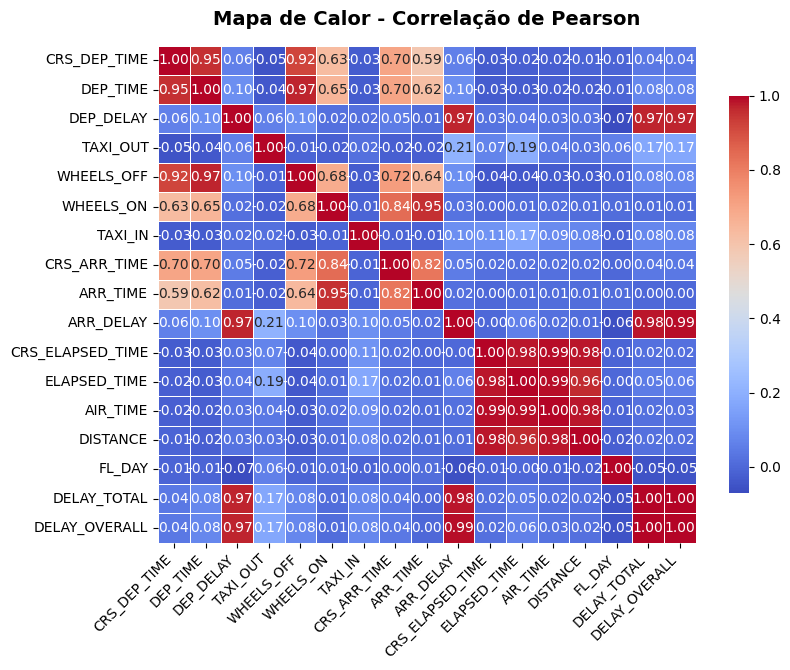

In [ ]:
# Heatmap
plt.figure(figsize=(len(analysis_columns) * 0.5, len(analysis_columns) * 0.4))
correlation_matrix = df[analysis_columns].corr(method='pearson')

sns.heatmap(
    correlation_matrix.round(2),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Mapa de Calor - Correlação de Pearson", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Apply analysis technique

### a. Flight segmentation

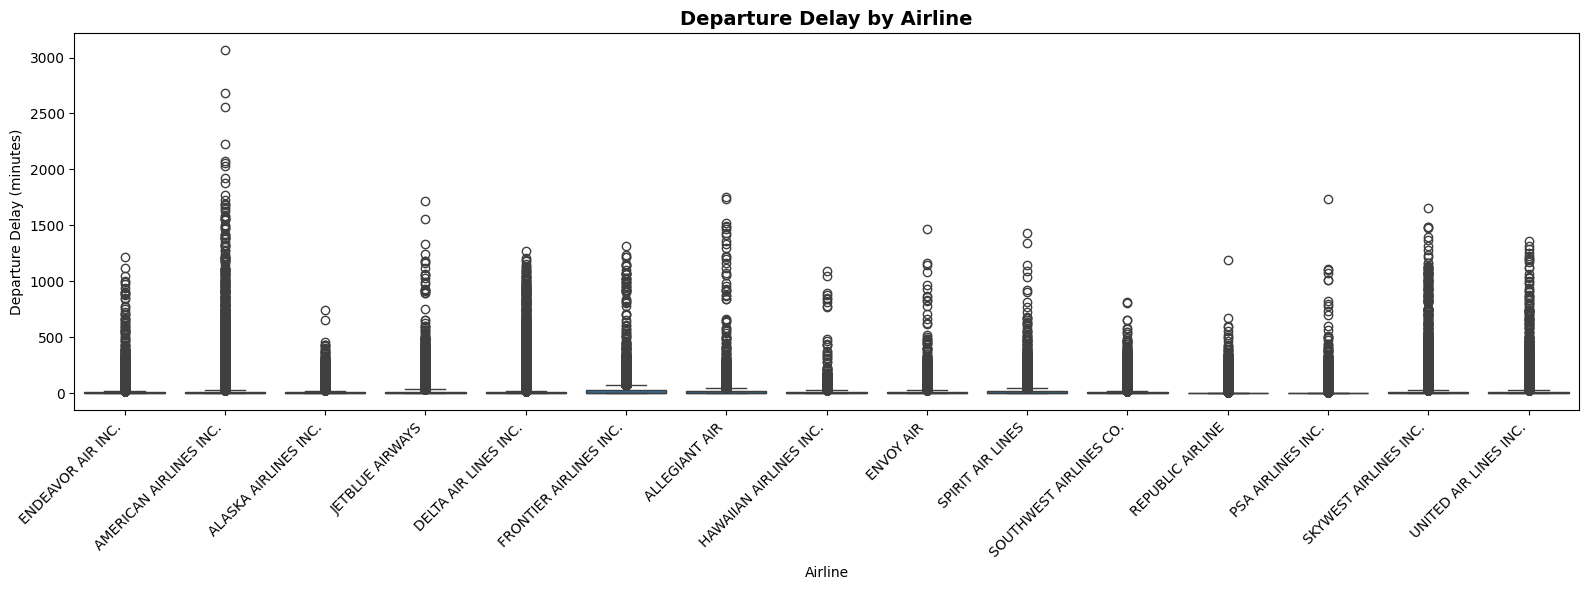

In [ ]:
# By Airline

plt.figure(figsize=(16, 6))
sns.boxplot(data=df, x="AIRLINE_Description", y="DELAY_OVERALL")
plt.title("Departure Delay by Airline", fontsize=14, fontweight="bold")
plt.xlabel("Airline")
plt.ylabel("Departure Delay (minutes)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

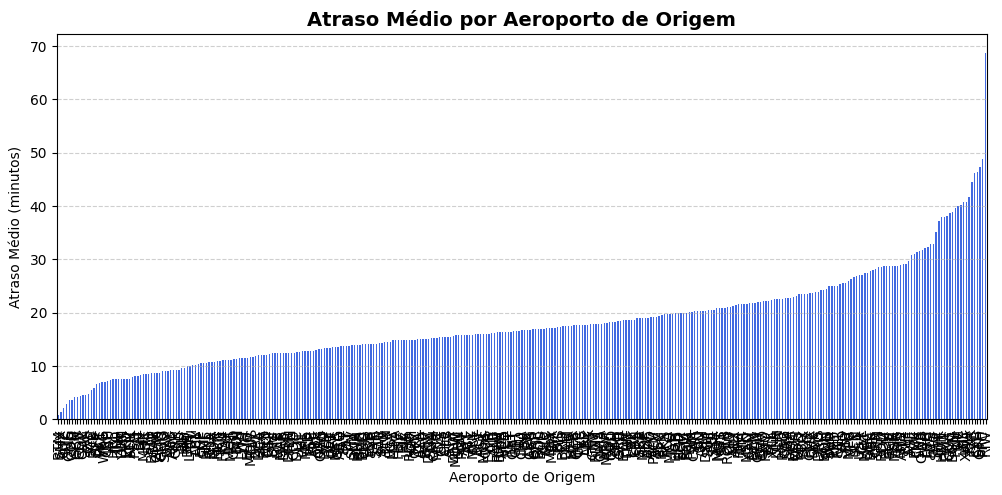

In [ ]:
# By origin Airline
delay_by_origin = df.groupby("ORIGIN")["DELAY_OVERALL"].mean().sort_values()

plt.figure(figsize=(12, 5))
delay_by_origin.plot(kind="bar", color="royalblue")
plt.title("Atraso Médio por Aeroporto de Origem", fontsize=14, fontweight="bold")
plt.xlabel("Aeroporto de Origem")
plt.ylabel("Atraso Médio (minutos)")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

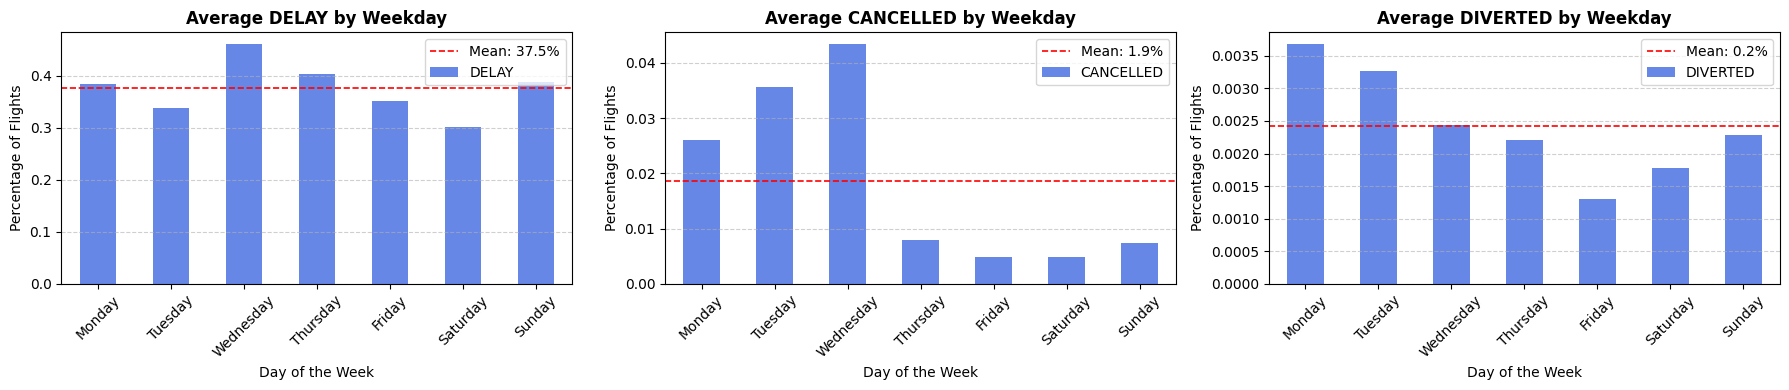

In [77]:
# Group by the average of the problematic variables by day of the week
problmec_metrics_by_weekday = df.groupby("DAY_OF_WEEK")[columns_problematic].mean()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
problmec_metrics_by_weekday = problmec_metrics_by_weekday.reindex(weekday_order)

fig, axes = plt.subplots(1, len(columns_problematic), figsize=(18, 4), sharey=False)

for i, col in enumerate(columns_problematic):
    problmec_metrics_by_weekday[col].plot(
        kind="bar",
        ax=axes[i],
        color="royalblue",
        alpha=0.8
    )
    mean_val = problmec_metrics_by_weekday[col].mean()
    axes[i].axhline(mean_val, color="red", linestyle="--", linewidth=1.2, label=f"Mean: {mean_val:.1%}")
    
    axes[i].set_title(f"Average {col} by Weekday", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Day of the Week")
    axes[i].set_ylabel("Percentage of Flights")
    axes[i].set_xticks(range(len(weekday_order)))
    axes[i].set_xticklabels(weekday_order, rotation=45)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)
    axes[i].legend()

plt.tight_layout()
plt.show()


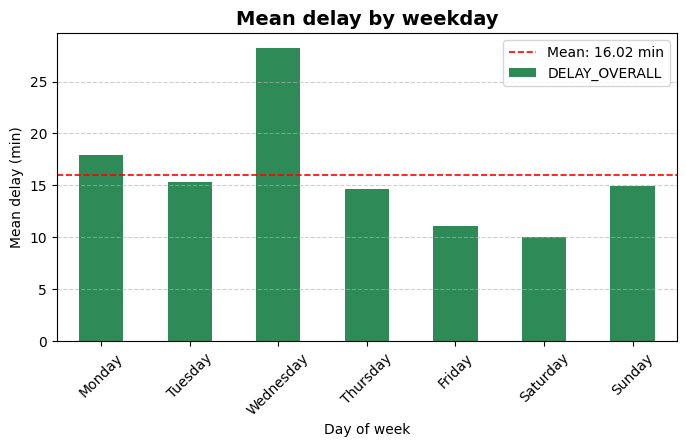

In [84]:
delay_by_weekday = df.groupby("DAY_OF_WEEK")["DELAY_OVERALL"].mean()

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
delay_by_weekday = delay_by_weekday.reindex(weekday_order)
mean_val = delay_by_weekday.mean()

fig, ax = plt.subplots(figsize=(8, 4))
delay_by_weekday.plot(kind="bar", color="seagreen", ax=ax)
ax.axhline(mean_val, color="red", linestyle="--", linewidth=1.2, label=f"Mean: {mean_val:.2f} min")
ax.set_title("Mean delay by weekday", fontsize=14, fontweight="bold")
ax.set_xlabel("Day of week")
ax.set_ylabel("Mean delay (min)")
ax.tick_params(axis='x', rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.legend()
plt.show()

C:\Users\Vitoria\AppData\Local\Temp\ipykernel_50388\2575126662.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_period = df.groupby("TIME_PERIOD")["DELAY_OVERALL"].mean()


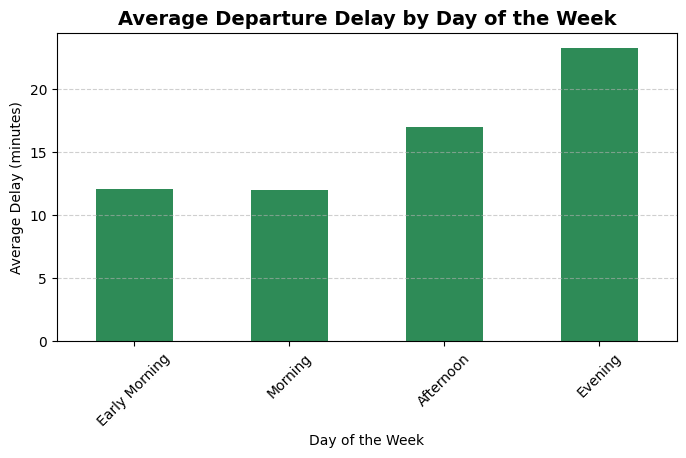

In [ ]:
# Agrupar pela média de atraso por dia
delay_by_period = df.groupby("TIME_PERIOD")["DELAY_OVERALL"].mean()

# Plot
plt.figure(figsize=(8, 4))
delay_by_period.plot(kind="bar", color="seagreen")
plt.title("Average Departure Delay by Day of the Week", fontsize=14, fontweight="bold")
plt.xlabel("Day of the Week")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

C:\Users\Vitoria\AppData\Local\Temp\ipykernel_50388\2294568006.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delay_by_hour = df.groupby("TIME_HOUR")["DELAY_OVERALL"].mean().reset_index()


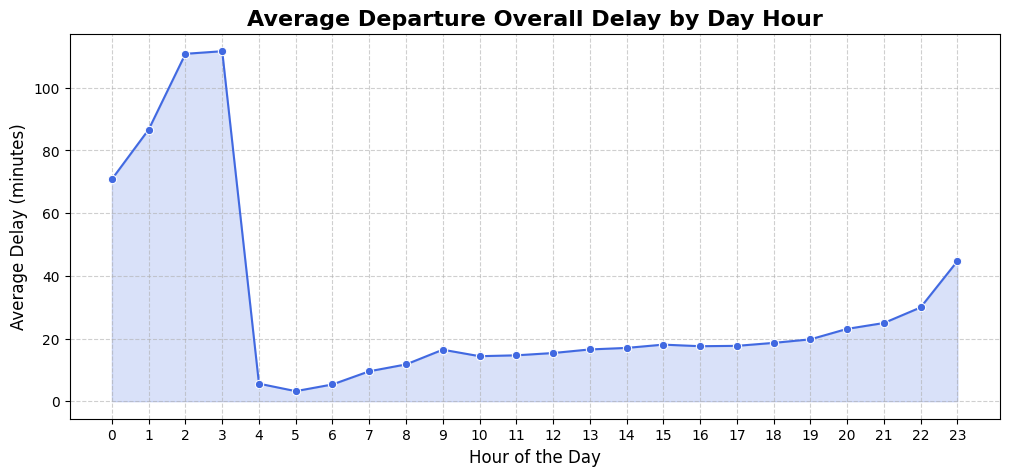

In [ ]:
# Categorization by time of day
df['TIME_HOUR'] = pd.cut(df['DEP_TIME'], bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400], 
                           labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], right=False)

delay_by_hour = df.groupby("TIME_HOUR")["DELAY_OVERALL"].mean().reset_index()

plt.figure(figsize=(12, 5))

sns.lineplot(x="TIME_HOUR", y="DELAY_OVERALL", data=delay_by_hour, marker="o", color="royalblue")
plt.fill_between(delay_by_hour["TIME_HOUR"], delay_by_hour["DELAY_OVERALL"], alpha=0.2, color="royalblue")
plt.title("Average Departure Overall Delay by Day Hour", fontsize=16, fontweight="bold")
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

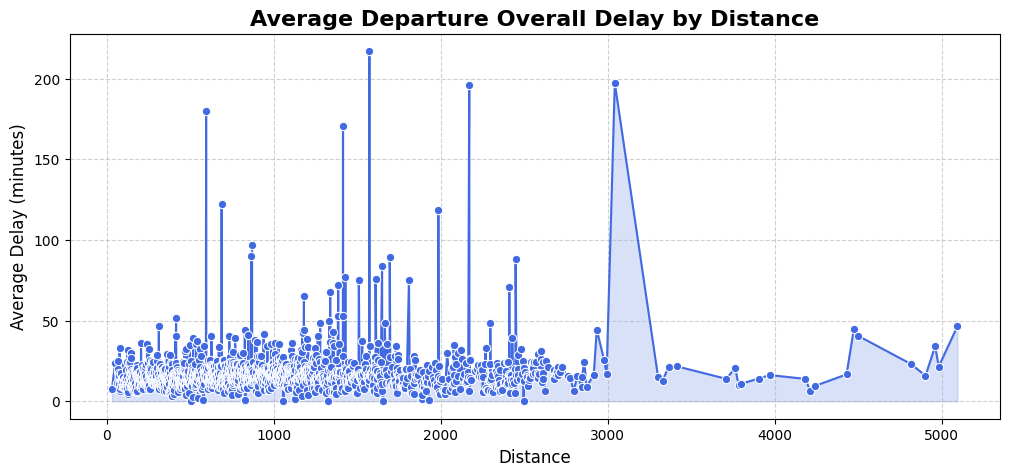

In [ ]:
# Categorization by fligh distance

delay_by_hour = df.groupby("DISTANCE")["DELAY_OVERALL"].mean().reset_index()

plt.figure(figsize=(12, 5))

sns.lineplot(x="DISTANCE", y="DELAY_OVERALL", data=delay_by_hour, marker="o", color="royalblue")
plt.fill_between(delay_by_hour["DISTANCE"], delay_by_hour["DELAY_OVERALL"], alpha=0.2, color="royalblue")
plt.title("Average Departure Overall Delay by Distance", fontsize=16, fontweight="bold")
plt.xlabel("Distance", fontsize=12)
plt.ylabel("Average Delay (minutes)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### b. Validate hypotheses

In [ ]:
# H1: Voos noturnos (após 18h) têm mais atraso que voos diurnos

# Criar variável binária: Noturno (1) ou Diurno (0)
df['is_night'] = (df['CRS_DEP_TIME'] >= 1800).astype(int)

# Separar grupos
night_delays = df[df['is_night'] == 1]['DEP_DELAY'].dropna()
day_delays   = df[df['is_night'] == 0]['DEP_DELAY'].dropna()

# Teste t
t_stat, p_val = ttest_ind(night_delays, day_delays, equal_var=False)
print("H1 - Teste T (Noturno vs Diurno)")
print(f"t={t_stat:.2f}, p={p_val:.4f}")

H1 - Teste T (Noturno vs Diurno)
t=28.40, p=0.0000


p < 0.05 → rejeita H0 = voos noturnos realmente têm atrasos diferentes dos diurnos

In [ ]:
# H2: Voos em sextas-feiras têm mais cancelamentos

# Tabela de contingência: Cancelado x Dia da Semana
crosstab = pd.crosstab(df['DAY_OF_WEEK'], df['CANCELLED'])

chi2, p_val, dof, expected = chi2_contingency(crosstab)
print("H2 - Qui-quadrado (Cancelamentos por Dia da Semana)")
print(f"Chi2={chi2:.2f}, p={p_val:.4f}")

H2 - Qui-quadrado (Cancelamentos por Dia da Semana)
Chi2=6230.82, p=0.0000
